In [2]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

# Metadata Access

import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

ds_train_transform = train_ds
ds_test_transform = test_ds

# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)


In [27]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

def visualize_fit(history):
    history_dict = history.history
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'b-o', label='Training acc')
    plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def buildModel(input_shape,optimizer,regularizer):
    input = Input(shape=input_shape,name = 'Input_layer')

    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name = 'First_Convolution')(input)
    pooling1 = MaxPooling2D(pool_size=(2, 2), name = 'First_Pooling')(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Second_Convolution')(pooling1)
    pooling2 = MaxPooling2D(pool_size=(2, 2), name = 'Second_Pooling')(conv2)
    conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Third_Convolution')(pooling2)
    pooling3 = MaxPooling2D(pool_size=(2, 2), name = 'Third_Pooling')(conv3)
    flat = Flatten(name = 'Flatten_Layer')(pooling3)
    dense1 = Dense(128, activation='relu', kernel_regularizer=regularizer, name = 'First_Dense')(flat)
    drop1 = Dropout(0.5, name = 'First_Dropouuuuuuut')(dense1)
    output = Dense(1, activation='sigmoid', name = 'Output_Layer')(drop1)

    model = Model(inputs=input,outputs=output)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'],weighted_metrics=[])
    return model


def fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss'):
    early_stopping = EarlyStopping(monitor=monitor, patience=patience, mode='min', verbose=1)
    checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor=monitor, mode='auto', verbose=0)
    history = model.fit(ds_train.batch(batch_size), verbose = 0, epochs=num_epochs,callbacks=[early_stopping, checkpoint],validation_data=ds_val.batch(batch_size))
    print(model.evaluate(ds_test.batch(batch_size)))
    visualize_fit(history)

In [5]:
dataset_size = ds_train_transform.reduce(0, lambda x, _: x + 1).numpy()
dataset_size

126865

In [24]:
ds_train_shuffle = ds_train_transform.shuffle(10000)
ds_train = ds_train_shuffle.skip(int(dataset_size * 0.2))
ds_test = ds_train_shuffle.take(int(dataset_size * 0.2))
ds_val = ds_test_transform

199/199 [==============================] - 5s 21ms/step - loss: 0.4046 - accuracy: 0.8699
[0.4045882523059845, 0.8698616623878479]


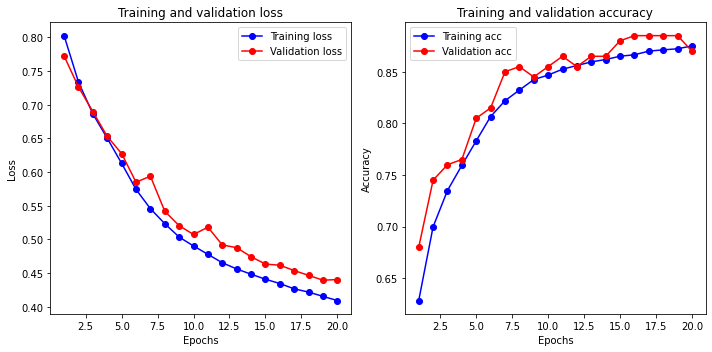

In [30]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')

Epoch 14: early stopping
199/199 [==============================] - 5s 22ms/step - loss: 0.3372 - accuracy: 0.8604
[0.33722084760665894, 0.8604028224945068]


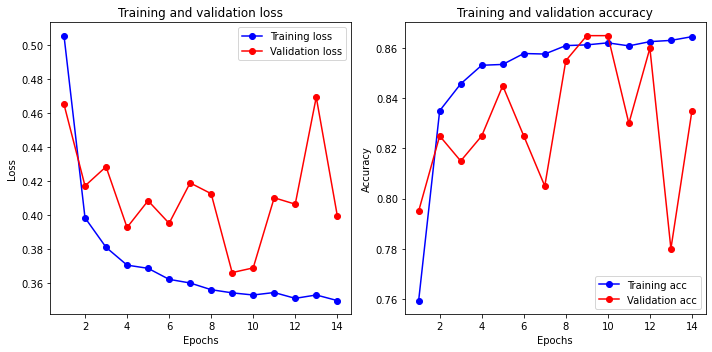

In [28]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')

Epoch 9: early stopping
199/199 [==============================] - 5s 21ms/step - loss: 0.3514 - accuracy: 0.8548
[0.3513811528682709, 0.8548457026481628]


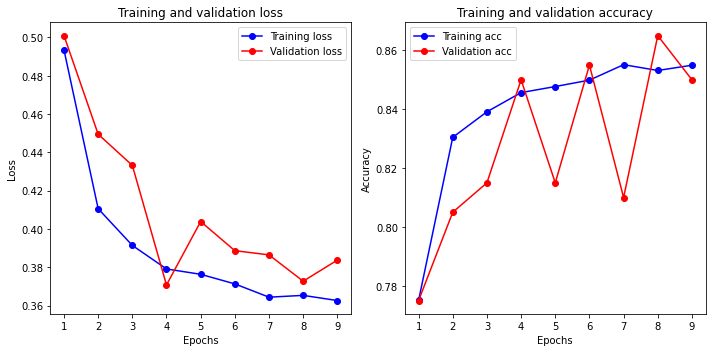

In [29]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')

Epoch 10: early stopping
199/199 [==============================] - 5s 21ms/step - loss: 0.2444 - accuracy: 0.9109
[0.2443673014640808, 0.9108501672744751]


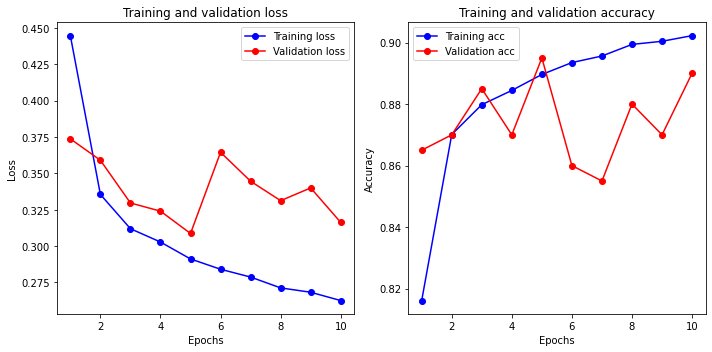

In [31]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')